<a href="https://colab.research.google.com/github/rajprakashbale1/bigdata/blob/main/Big_Data_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data download from Kaggle using Kaggle API

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!kaggle datasets download kvnpatel/fruits-vegetable-detection-for-yolov4

100% 5.84G/5.85G [00:50<00:00, 179MB/s]
100% 5.85G/5.85G [00:51<00:00, 123MB/s]


In [3]:
# Mounting google drive so that we don't have to keep downloading the dataset from Kaggle 
from google.colab import drive
drive.mount('/content/big_data')

Mounted at /content/big_data


In [8]:
# saving the mounted root path for easy access
root_path = 'big_data/My Drive/423/'

In [9]:
# Unzipping files into the google drive folder
import zipfile

with zipfile.ZipFile('./fruits-vegetable-detection-for-yolov4.zip','r') as zipref:
    zipref.extractall('./big_data/My Drive/423')

In [10]:
# Renaming files and structuring them for easy access
!mv ./big_data/MyDrive/423/obj\ \(1\)/obj ./big_data/MyDrive/423/Train
!mv ./big_data/MyDrive/423/test/test ./big_data/MyDrive/423/Test

## 2. Creating Test and Train Datasets

In [4]:
# saving the mounted root path for easy access
root_path = 'big_data/My Drive/423/'

In [5]:
import glob, os

train_files = glob.glob(os.path.join(root_path,'Train','*.jpg'))
test_files = glob.glob(os.path.join(root_path,'Test','*.jpg'))

In [6]:
import pandas as pd

df_train = pd.DataFrame(train_files, columns=['path'])
df_test = pd.DataFrame(test_files, columns=['path'])

In [7]:
def get_labels(x):
    return x.split('_')[3].split('-')[0]

df_train['label'] = df_train.path.apply(lambda x: get_labels(x))
df_test['label'] = df_test.path.apply(lambda x: get_labels(x))

## 2.1 Understanding the split of our data in train and test sets

In [8]:
train_stats = pd.DataFrame(df_train.label.value_counts())
train_stats['data_cat'] = 'train'
train_stats['pcts'] = round((train_stats['label']/sum(train_stats.label))*100,2)
train_stats

,label,data_cat,pcts
chilli,630,train,15.98
lemon,618,train,15.68
tomato,613,train,15.55
apple,607,train,15.40
banana,604,train,15.32
grapes,604,train,15.32
raspberry,149,train,3.78
blackberries,117,train,2.97


In [9]:
test_stats = pd.DataFrame(df_test.label.value_counts())
test_stats['data_cat'] = 'test'
test_stats['pcts'] = round((test_stats['label']/sum(test_stats.label))*100,2)
test_stats

,label,data_cat,pcts
banana,110,test,16.92
lemon,103,test,15.85
apple,100,test,15.38
chilli,98,test,15.08
grapes,96,test,14.77
tomato,94,test,14.46
raspberry,26,test,4.00
blackberries,23,test,3.54


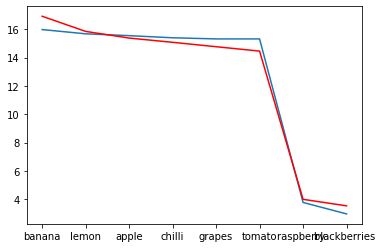

In [10]:
ax = train_stats.pcts.plot(kind='line')
test_stats.pcts.plot(kind='line',ax=ax,color='r')

This ensures that the test and train are similar in distribution

2.2 Data Generator for training

In [65]:
df_train['label'].unique()

array(['apple', 'grapes', 'lemon', 'tomato', 'banana', 'raspberry ',
       'chilli', 'blackberries '], dtype=object)

In [25]:
# converting categorical variables into numbers for training
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_train['category'] = encoder.fit_transform(df_train['label'])
df_test['category'] = encoder.fit_transform(df_test['label'])

Checking if the categories are labelled the same in both test and train

In [26]:
df_train.groupby('label').agg(pd.Series.mode)

,path,category
label,,
apple,[big_data/My Drive/423/Train/0_1_apple_wb_7.jp...,0
banana,[big_data/My Drive/423/Train/10_0_banana_wb_28...,1
blackberries,[big_data/My Drive/423/Train/147_0_blackberrie...,2
chilli,[big_data/My Drive/423/Train/125_0_chilli_wob_...,3
grapes,[big_data/My Drive/423/Train/100_0_grapes_wob_...,4
lemon,[big_data/My Drive/423/Train/103_1_lemon_wb_14...,5
raspberry,[big_data/My Drive/423/Train/112_1_raspberry -...,6
tomato,[big_data/My Drive/423/Train/105_0_tomato_wb_4...,7


In [27]:
df_test.groupby('label').agg(pd.Series.mode)

,path,category
label,,
apple,[big_data/My Drive/423/Test/0_0_apple_wb_7.jpg...,0
banana,[big_data/My Drive/423/Test/115_4_banana_wob_1...,1
blackberries,[big_data/My Drive/423/Test/147_2_blackberries...,2
chilli,[big_data/My Drive/423/Test/125_6_chilli_wob_2...,3
grapes,[big_data/My Drive/423/Test/100_6_grapes_wob_7...,4
lemon,[big_data/My Drive/423/Test/103_0_lemon_wb_14....,5
raspberry,[big_data/My Drive/423/Test/112_0_raspberry - ...,6
tomato,[big_data/My Drive/423/Test/105_1_tomato_wb_49...,7


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_df, validate_df = train_test_split(df_train, test_size=0.20, random_state=420, stratify=df_train.label)
# train_df = train_df.reset_index(drop=True)
# validate_df = validate_df.reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=180,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.15,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    df_train, 
    directory = "./", 
    x_col='path',
    y_col='label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    seed=420
)

validation_generator = train_datagen.flow_from_dataframe(
    df_train, 
    directory = "./", 
    x_col='path',
    y_col='label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    seed=420
)

test_generator = test_datagen.flow_from_dataframe(
    df_test, 
    directory = "./", 
    x_col='path',
    y_col='label',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=32,
    seed=420
)

Found 3351 validated image filenames belonging to 8 classes.
Found 591 validated image filenames belonging to 8 classes.
Found 650 validated image filenames belonging to 8 classes.


## 3. Model

In [54]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import accuracy_score
import numpy as np


def create_model():
    model = Sequential()
    model.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same',input_shape=(128,128,3)))
    model.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(8,activation='softmax'))
    model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model = create_model()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 conv2d_21 (Conv2D)          (None, 128, 128, 16)      2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 32)        9248      
                                                      

In [57]:
history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 5,
    epochs = 20,
    validation_steps = 10,
    verbose = 1
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
5/5 [==============================] - 25s 5s/step - loss: 2.0649 - accuracy: 0.1562
Epoch 2/20
5/5 [==============================] - 25s 5s/step - loss: 2.0704 - accuracy: 0.1500
Epoch 3/20
5/5 [==============================] - 25s 5s/step - loss: 2.0095 - accuracy: 0.2250
Epoch 4/20
5/5 [==============================] - 25s 5s/step - loss: 2.0680 - accuracy: 0.1312
Epoch 5/20
5/5 [==============================] - 25s 5s/step - loss: 2.0456 - accuracy: 0.1250
Epoch 6/20
5/5 [==============================] - 25s 5s/step - loss: 2.0639 - accuracy: 0.1750
Epoch 7/20
5/5 [==============================] - 25s 5s/step - loss: 2.0457 - accuracy: 0.1937
Epoch 8/20
5/5 [==============================] - 25s 5s/step - loss: 2.0299 - accuracy: 0.2062
Epoch 9/20
5/5 [==============================] - 25s 5s/step - loss: 2.0292 - accuracy: 0.1625
Epoch 10/20
5/5 [==============================] - 25s 5s/step - loss: 2.0466 - accuracy: 0.1500
Epoch 11/20
5/5 [======================

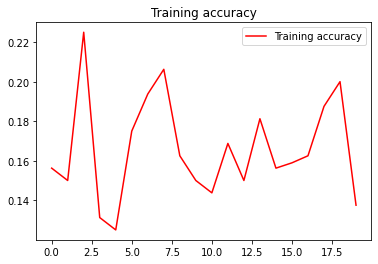

<Figure size 432x288 with 0 Axes>

In [60]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [61]:
y_pred_raw = model.predict_generator(test_generator)
y_pred = np.argmax(y_pred_raw,axis=1)
print(metrics.classification_report(df_test.category.values,y_pred))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.00      0.00      0.00       110
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        98
           4       0.15      1.00      0.26        96
           5       0.00      0.00      0.00       103
           6       0.00      0.00      0.00        26
           7       0.00      0.00      0.00        94

    accuracy                           0.15       650
   macro avg       0.02      0.12      0.03       650
weighted avg       0.02      0.15      0.04       650



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
print(accuracy_score(df_test.category.values,y_pred))

0.15692307692307692


Without using ImageGenerator

In [88]:
import cv2

def img_and_label_generator(df):
    images = []
    labels = []
    for _,row in df.iterrows():
        img = cv2.imread(os.path.join('./',row.path))
        img = cv2.resize(img,(128,128))
        images.append(img)
        labels.append(row.label)
    labels_df = pd.get_dummies(labels)
    labels = labels_df.values
    images = np.array(images)
    return images, labels, labels_df

train_images, train_labels, train_labels_with_rep = img_and_label_generator(df_train)
test_images, test_labels, test_labels_with_rep = img_and_label_generator(df_test)
x_train,x_val,y_train,y_val = train_test_split(train_images,train_labels,random_state=420, test_size=0.15)

In [89]:
import joblib

joblib.dump(train_images, os.path.join('./',root_path,'train_images_list.pkl'))
joblib.dump(train_labels, os.path.join('./',root_path,'train_labels_list.pkl'))
joblib.dump(test_images, os.path.join('./',root_path,'test_images_list.pkl'))
joblib.dump(train_labels, os.path.join('./',root_path,'train_labels_list.pkl'))

joblib.dump(x_train, os.path.join('./',root_path,'x_train_list.pkl'))
joblib.dump(x_val, os.path.join('./',root_path,'x_val_list.pkl'))
joblib.dump(y_train, os.path.join('./',root_path,'y_train_list.pkl'))
joblib.dump(y_val, os.path.join('./',root_path,'y_val_list.pkl'))

['./big_data/My Drive/423/y_val_list.pkl']

In [91]:
earlystopper = EarlyStopping(monitor='val_accuracy',patience=10,verbose=1)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,patience=2,verbose=1,mode='max',min_lr=0.00001)
checkpointer = ModelCheckpoint('bestmodel.h5',monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True)

new_model = create_model()
history2 = new_model.fit(x_train, y_train, epochs=50, batch_size=50,validation_data=(x_val,y_val),
                     callbacks=[earlystopper,reduce_learning_rate,checkpointer])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 1.9139 - accuracy: 0.2009
Epoch 1: val_accuracy improved from -inf to 0.36655, saving model to bestmodel.h5
67/67 [==============================] - 23s 63ms/step - loss: 1.9139 - accuracy: 0.2009 - val_loss: 1.6637 - val_accuracy: 0.3666 - lr: 1.0000e-04
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 1.4107 - accuracy: 0.4633
Epoch 2: val_accuracy improved from 0.36655 to 0.51520, saving model to bestmodel.h5
67/67 [==============================] - 4s 58ms/step - loss: 1.4107 - accuracy: 0.4633 - val_loss: 1.2527 - val_accuracy: 0.5152 - lr: 1.0000e-04
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.9859 - accuracy: 0.6490
Epoch 3: val_accuracy improved from 0.51520 to 0.72804, saving model to bestmodel.h5
67/67 [==============================] - 4s 58ms/step - loss: 0.9859 - accuracy: 0.6490 - val_loss: 0.7893 - val_accuracy: 0.7280 - lr: 1.0000e-04
Epoch 4/50
67/67 [======

In [92]:
!mv bestmodel.h5 ./big_data/MyDrive/423/bestmodel.h5

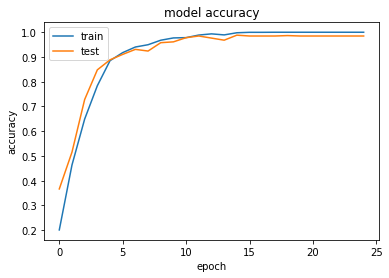

In [93]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

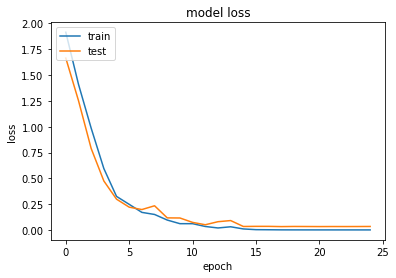

In [94]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [96]:
label_dictionary = {}
for idx,col in enumerate(train_labels_with_rep.columns):
    label_dictionary[idx] = col

In [ ]:
from google.colab.patches import cv2_imshow as img_show
import random

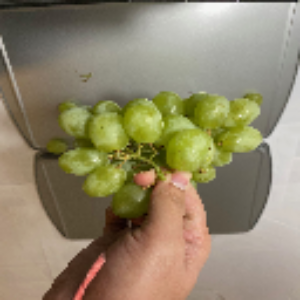

grapes


In [112]:
_index = random.randint(0,len(test_labels))
check_img = test_images[_index]
img_show(cv2.resize(check_img,(300,300)))
check_label = test_labels[_index]

prediction = model.predict(np.array([check_img]))
print(label_dictionary[np.argmax(prediction)])

In [115]:
y_pred_raw = new_model.predict(np.array(test_images))
y_pred = np.argmax(y_pred_raw,axis=1)
y_pred

array([3, 5, 5, 6, 1, 4, 7, 4, 7, 7, 7, 1, 4, 1, 5, 6, 5, 3, 3, 0, 3, 3,
       1, 3, 1, 0, 3, 3, 1, 5, 6, 5, 4, 4, 7, 7, 7, 5, 7, 7, 7, 7, 4, 4,
       1, 3, 4, 7, 5, 3, 4, 5, 3, 0, 0, 0, 3, 3, 6, 5, 1, 4, 0, 4, 4, 4,
       4, 4, 7, 7, 7, 5, 7, 7, 7, 7, 4, 4, 4, 4, 4, 1, 1, 3, 3, 0, 3, 3,
       3, 3, 1, 5, 1, 1, 4, 4, 7, 7, 5, 7, 5, 4, 7, 7, 4, 4, 4, 4, 4, 1,
       5, 3, 3, 3, 0, 3, 0, 0, 1, 4, 3, 3, 4, 4, 4, 5, 7, 0, 4, 4, 7, 7,
       7, 7, 7, 5, 4, 4, 3, 4, 4, 1, 3, 3, 3, 3, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 3, 3, 1, 4, 4, 4, 4, 4, 7, 4, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 3, 7, 5, 7, 7, 7, 4, 4, 4, 3, 1, 0, 3, 3, 3, 0, 0, 0, 0, 0, 5,
       5, 3, 3, 1, 1, 1, 1, 7, 6, 1, 1, 6, 5, 1, 4, 4, 4, 4, 2, 2, 7, 4,
       5, 0, 7, 5, 5, 5, 5, 7, 5, 5, 7, 2, 2, 4, 4, 4, 0, 4, 4, 1, 5, 6,
       1, 6, 6, 7, 1, 1, 1, 1, 1, 0, 3, 5, 3, 3, 0, 1, 1, 0, 0, 0, 0, 3,
       3, 3, 4, 3, 0, 0, 0, 0, 0, 1, 0, 0, 3, 5, 5, 1, 1, 5, 5, 5, 1, 1,
       1, 4, 4, 4, 7, 5, 2, 7, 5, 5, 1, 7, 5, 5, 5,

In [120]:
real_labels = [np.argmax(x) for x in test_labels]

In [122]:
print(metrics.classification_report(real_labels,y_pred))
print("Model Accuracy Score: ",accuracy_score(real_labels,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       100
           1       0.99      0.97      0.98       110
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        98
           4       0.93      0.99      0.96        96
           5       1.00      0.97      0.99       103
           6       1.00      0.96      0.98        26
           7       0.99      0.99      0.99        94

    accuracy                           0.98       650
   macro avg       0.99      0.98      0.99       650
weighted avg       0.99      0.98      0.98       650

Model Accuracy Score:  0.9846153846153847
